In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
from anndata import AnnData, read_h5ad
from scipy.stats import pearsonr, norm, ttest_ind, fisher_exact
from statsmodels.stats.multitest import multipletests
import seaborn as sns

import batchglm.api as glm
import diffxpy.api as de


/Users/colleenmclaughlin/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import warnings
warnings.filterwarnings('ignore')

sc.settings.verbosity = 3             
sc.settings.set_figure_params(dpi=100, dpi_save=600)

# use scanpy to plot co-receptor expression

In [3]:
ORN_all = read_h5ad('/data/ORN_all_annotated_GH.h5ad')
mars_adult = read_h5ad('/data/Figure5/mars_adult_clust_reads_batch_type.h5ad')

In [4]:
ORN_adult = ORN_all[(ORN_all.obs.stage == 'adult') & (ORN_all.obs.all_types != 'NaN')]

In [5]:
ORN_adult.obs.all_types.cat.reorder_categories (['DA1','DC1','DL3','VA1d', 'VA1v','DM1',
       'DM2', 'DM4', 'V', 'VA2','D','DC2','DL5','VA6_DC3_DM3','VM3_VA5',
         'DL2d/v_DP1l_VC3l','VL1_VM1', 'DP1m_DC4','VP1l_VP3', 'VP4_VP1d_VP2',], inplace=True)

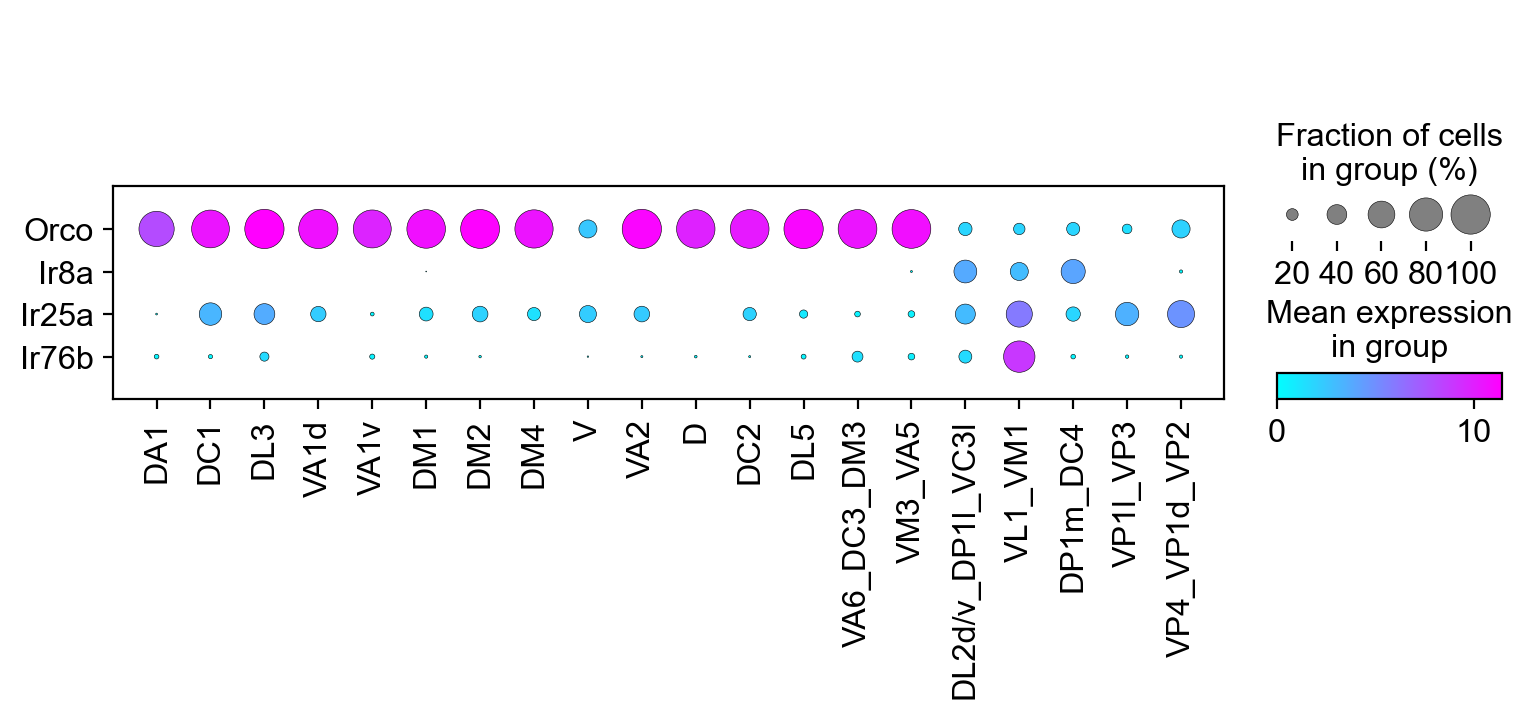

In [6]:
co_receptors = ['Orco', 'Ir8a', 'Ir25a', 'Ir76b']
sc.pl.dotplot(ORN_adult, co_receptors, groupby='all_types', color_map='cool', dot_max = 1.0,
              swap_axes=True)

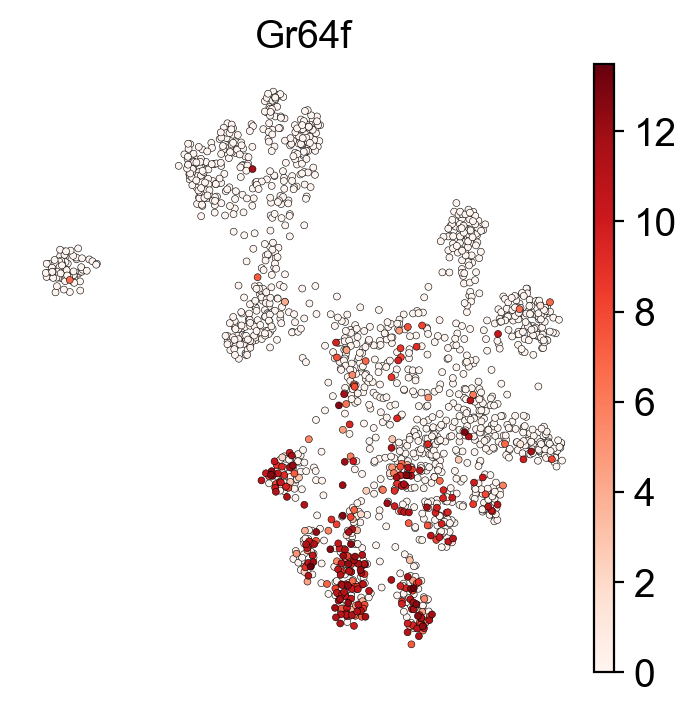

In [7]:
sc.pl.umap(mars_adult, color=['Gr64f'], size=25,edgecolors='k', color_map='Reds',edgecolor='k',
           linewidths=0.2, frameon=False)

# open counts matrix of all adult ORNs to calculate % co-receptor co-expression

In [8]:
#open matrix with all adult ORNs 
df = pd.read_csv('../data/htseq_ORN_nuclei_LogCPM_17plates_addintron_hq50k_neuron2-5.tab.gz',  sep="\t", header=0, index_col=0)
df_libs_all = pd.read_csv('../data/PN_ORN_libs_CNM.csv', sep=",", header=0, index_col=0)


In [9]:
names_ORNs = []
with open ('../resources/names_ORN_hq_24h_adult_lamGFP_noAN.txt') as f:
    for line in f:
        names_ORNs.append(line.rstrip())
len(names_ORNs)

3133

In [10]:
# Get names of adult ORNs
selector7 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P1") 
selector8 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P2") 
selector9 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P3") 
selector10 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P5") 
selector11 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P6") 
selector12 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P7") 
selector13 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P8") 
selector14 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P9") 
selector15 = (df_libs_all["genotype"] == "ORNnuclei_adult_nSybUNC84GFP_P10") 
selector16 = (df_libs_all['genotype'] == "ORNnuclei_adult_nSybLam_P2")
selector17 = (df_libs_all['genotype'] == "ORNnuclei_adult_nSybLam_P3")

ORNs_adult = [x for x in list(df.columns) if ((x in df_libs_all.loc[selector7].index) 
                      or (x in df_libs_all.loc[selector8].index) 
                      or (x in df_libs_all.loc[selector9].index)
                      or (x in df_libs_all.loc[selector10].index)
                      or (x in df_libs_all.loc[selector11].index)
                      or (x in df_libs_all.loc[selector12].index)
                      or (x in df_libs_all.loc[selector13].index)
                      or (x in df_libs_all.loc[selector14].index)
                      or (x in df_libs_all.loc[selector15].index)
                      or (x in df_libs_all.loc[selector16].index)
                      or (x in df_libs_all.loc[selector17].index))
                      and  x in names_ORNs]


print('adult ORNs:'), len(ORNs_adult)


adult ORNs:


(None, 1891)

In [11]:
# Filter for these cells

df_adult = df[list(ORNs_adult)]

print ("ORN_adult:"), df_adult.shape

ORN_adult:


(None, (17472, 1891))

In [12]:
Ir8a = ['Ir8a']
names_Ir8a = df_adult.columns[np.where(np.sum(df_adult.loc[Ir8a]>=5))]
df_Ir8a = df_adult[names_Ir8a]

Ir25a = ['Ir25a']
names_Ir25a = df_adult.columns[np.where(np.sum(df_adult.loc[Ir25a]>=5))]
df_Ir25a = df_adult[names_Ir25a]

Ir76b = ['Ir76b']
names_Ir76b = df_adult.columns[np.where(np.sum(df_adult.loc[Ir76b]>=5))]
df_Ir76b = df_adult[names_Ir76b]

print('# cells expressing Ir8a:'), len(names_Ir8a), print('# cells expressing Ir25a:'), len(names_Ir25a), print('# cells expressing Ir76b:'), len(names_Ir76b)                                                            
                                                                                                                

# cells expressing Ir8a:
# cells expressing Ir25a:
# cells expressing Ir76b:


(None, 95, None, 362, None, 126)

In [13]:
orco = ['Orco']
names_orco = df_Ir8a.columns[np.where(np.sum(df_Ir8a.loc[orco]>=5))]
df_Ir8a_orco = df_Ir8a[names_orco]

percent_Ir8a_orco = (len(names_orco)/len(names_Ir8a))*100
percent_Ir8a_noO = 100-percent_Ir8a_orco
print(percent_Ir8a_orco), print(percent_Ir8a_noO)

31.57894736842105
68.42105263157895


(None, None)

In [14]:
orco = ['Orco']
names_orco = df_Ir25a.columns[np.where(np.sum(df_Ir25a.loc[orco]>=5))]
df_Ir25a_orco = df_Ir25a[names_orco]

percent_Ir25a_orco = (len(names_orco)/len(names_Ir25a))*100
percent_Ir25a_noO = 100- percent_Ir25a_orco
print(percent_Ir25a_orco), print(percent_Ir25a_noO)

57.73480662983425
42.26519337016575


(None, None)

In [15]:
orco = ['Orco']
names_orco = df_Ir76b.columns[np.where(np.sum(df_Ir76b.loc[orco]>=5))]
df_Ir76b_orco = df_Ir76b[names_orco]

percent_Ir76b_orco = (len(names_orco)/len(names_Ir76b))*100
percent_Ir76b_noO = 100-percent_Ir76b_orco
print(percent_Ir76b_orco), print(percent_Ir76b_noO)

57.936507936507944
42.063492063492056


(None, None)

(<Figure size 504x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1531abad0>)

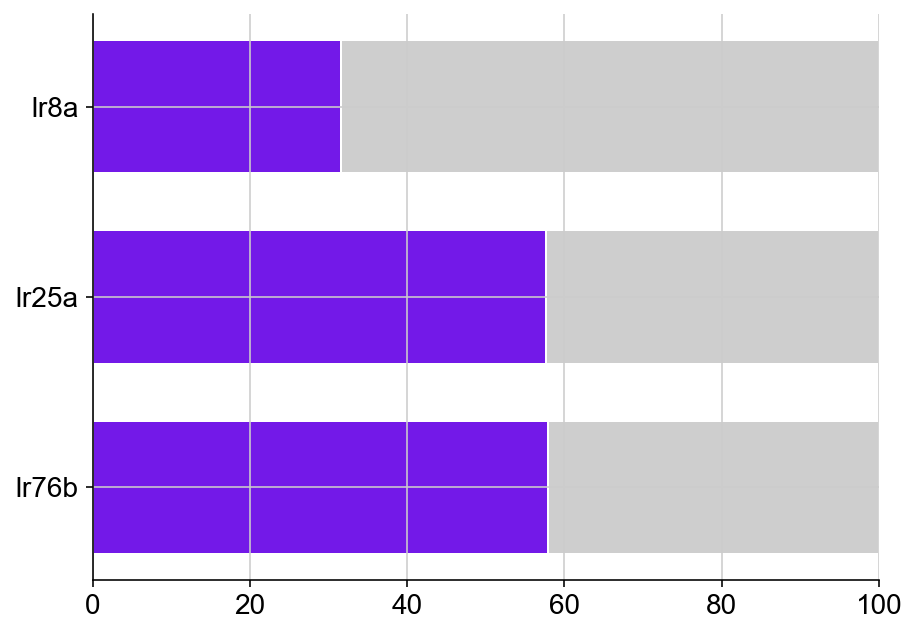

In [16]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

category_names = ['Orco', 'Ir' ]

results = {
    'Ir8a': [percent_Ir8a_orco,  percent_Ir8a_noO],
    'Ir25a': [percent_Ir25a_orco,percent_Ir25a_noO],
    'Ir76b': [percent_Ir76b_orco,  percent_Ir76b_noO],}
   
colors = ['#7319E8','#CECECE' ]

def plot(results, category_names):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = colors
    (np.linspace(0.75, 0.75, data.shape[1]))

    fig, ax = plt.subplots(figsize=(7,5))
    ax.invert_yaxis()
    ax.xaxis.set_visible(True)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.7,edgecolor='white',
                label=colname, color=color,)
        xcenters = starts + widths / 1.2

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
   
    return fig, ax
    
plot(results, category_names)


